<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
# !pip install -r requirements.txt
# !pip install tensorflow[and-cuda]

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import re
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from tensorflow.keras.layers import Conv2DTranspose, Dense, Reshape, LSTM, Dropout, TimeDistributed, RepeatVector, Input
from sklearn.metrics import recall_score, precision_score
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
# weet niet of dit bovenste stukje code nodig is, maar ik heb het er maar in gezet
tf.config.list_physical_devices('GPU')
# np.random.seed(42)
# tf.random.set_seed(42)
# random.seed(42)

2024-12-13 19:50:38.095045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 19:50:38.095119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 19:50:38.096057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 19:50:38.103408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 19:50:38.830682: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.15.0'

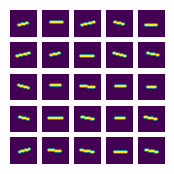

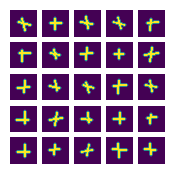

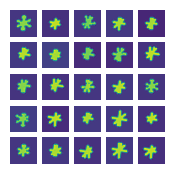

In [4]:
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images(sign='-'))
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='*'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    # Combine the two lists into a single list of tuples
    combined_text = list(zip(X_text, y_text))
    combined_img = list(zip(X_img, y_img))
    combined = list(zip(combined_text, combined_img))
    random.shuffle(combined)
    # unpack combined
    X_text, y_text = zip(*[x for x, _ in combined])
    X_img, y_img = zip(*[x for _, x in combined])
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

Query #4494

X_text: "20+81" = y_text: "101"


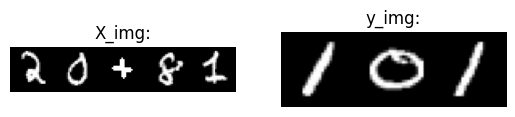

Query #4370

X_text: "45+57" = y_text: "102"


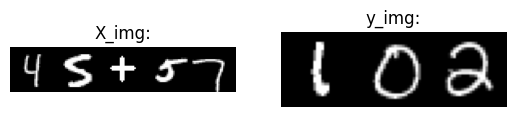

Query #2990

X_text: "0+29 " = y_text: "29 "


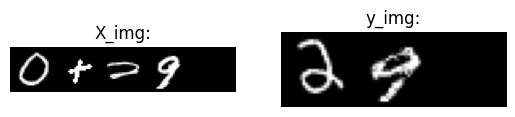

Query #6257

X_text: "67-52" = y_text: "15 "


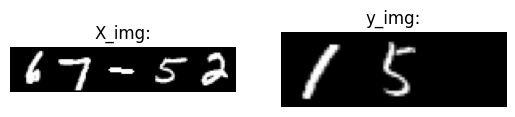

Query #6001

X_text: "1+82 " = y_text: "83 "


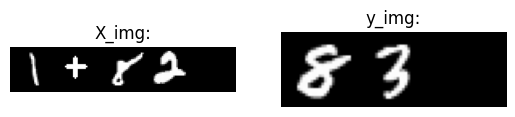

Query #8763

X_text: "42-6 " = y_text: "36 "


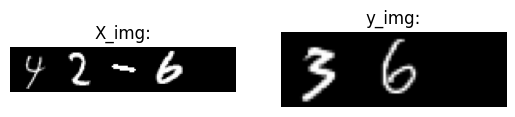

Query #6587

X_text: "31+2 " = y_text: "33 "


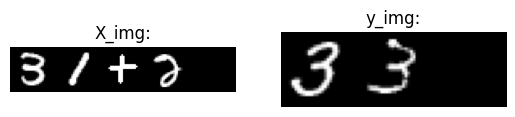

Query #9950

X_text: "20+48" = y_text: "68 "


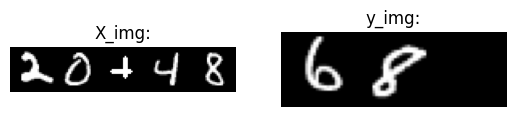

Query #5053

X_text: "70+92" = y_text: "162"


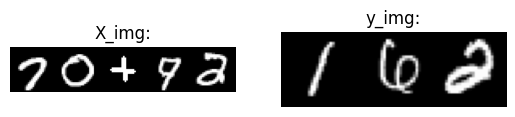

Query #6020

X_text: "26+20" = y_text: "46 "


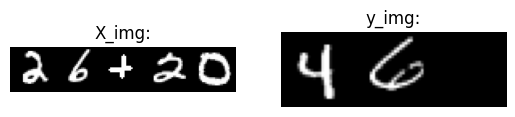

In [6]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks
def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    return predicted
# TODO set unrandom but for debug its fine
X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)
random_numbers = np.random.randint(0, len(X_text), 4)
print(X_text_onehot.shape, y_text_onehot.shape)
for i in range(4):
    print(y_text_onehot[random_numbers[i]])
    print(decode_labels(y_text_onehot[random_numbers[i]]))

(20000, 5, 13) (20000, 3, 13)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
146
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
123
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
85 
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
48 


In [8]:
def check_classification(y_pred, y_true):
  bools = [y_pred[i] == y_true[i] for i in range(len(y_pred))]
  correct = np.where(bools)[0]
  incorrect = np.where(np.logical_not(bools))[0]
  return len(correct), len(incorrect), np.array(correct), np.array(incorrect, dtype=int)

def decode_all(predictions):
    decoded_predictions = []
    for i in range(len(predictions)):
        decoded_predictions.append(decode_labels(predictions[i]))
    return decoded_predictions

In [9]:
# we need to convert our strings to integers. 
# Note that due to white spacing we must first subtract any white spacing, before converting to integers. 
# Furthermore, we should note exceptions such as '- ' which is basically just a black, we should completely remove these, but do count them up. 
# These are of course completely wrong as no number is present.

def process_strings(input_list):
    cleaned_list = []
    invalid_count = 0

    for item in input_list:
        cleaned_item = item.replace(" ", "")
        # # check if there is only a + or - in the string
        if re.search(r"[+-]", cleaned_item[1:]) or re.search(r"[^0-9+-]", cleaned_item) or not cleaned_item or cleaned_item == '-':
            invalid_count += 1
            continue


        cleaned_item_int = int(cleaned_item)
        cleaned_list.append(cleaned_item_int)
    return cleaned_list, invalid_count

# for debugging:
input_strings = [" 92 ", "30", "-67", "  -  20 ", "12 - 34", "49-", '']
cleaned_numbers, invalid_count = process_strings(input_strings)

print("Cleaned Numbers:", cleaned_numbers)
print("Invalid Count:", invalid_count)

Cleaned Numbers: [92, 30, -67, -20]
Invalid Count: 3


In [10]:
# visualize the wrongly classified instances (2.2)
# Set the batch size

def plot_wrong_classified(cleaned_wrong_classified, cleaned_true,batch_size=300):

    # Get the total number of instances
    total_instances = len(cleaned_wrong_classified)

    # Calculate the number of subplots needed
    num_subplots = int(np.ceil(total_instances / batch_size))

    # Calculate the number of rows and columns for the subplot grid
    num_rows = int(np.sqrt(num_subplots))
    num_cols = int(np.ceil(num_subplots / num_rows))

    # Create a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 12))

    # Flatten the axs array if it's a multi-dimensional array
    axs = axs.flatten()

    # Plot instances in batches of 250
    for i in range(num_subplots):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, total_instances)

        # Use the current subplot
        ax = axs[i]

        # Plot instances that were wrongly labeled
        ax.scatter(range(start_index, end_index), cleaned_wrong_classified[start_index:end_index],
                color='red', marker='x', label='Wrong predicted values', s=25)

        # Plot true values of the wrongly classified instances
        ax.scatter(range(start_index, end_index), cleaned_true[start_index:end_index],
                color='blue', marker='o', label='True values', s=25, alpha=0.4)

        # Customize the subplot
        ax.set_xlabel('Instance index')
        ax.set_ylabel('Instance value')
        ax.set_title(f'Subplot {i+1}')
        ax.grid()

        # Create a legend with unique labels
        ax.legend()

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    # Display the grid of subplots
    plt.show()

---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [11]:
def build_text2text_model(num_encode_layers=1,num_decode_layers=1,max_answer_length=3):
    text2text = tf.keras.Sequential()
    text2text.add(Input(shape=(max_query_length, len(unique_characters))))
    hidden_units = 128
    for i in range(num_encode_layers):
        text2text.add(LSTM(hidden_units, return_sequences=(i < num_encode_layers - 1)))
        text2text.add(Dropout(0.2))
    # Repeat the context vector for decoding
    text2text.add(RepeatVector(max_answer_length))

    # Decoder: Add num_decode_layers LSTM layers
    for _ in range(num_decode_layers):
        text2text.add(LSTM(hidden_units, return_sequences=True))
        text2text.add(Dropout(0.2))

    # Output layer: TimeDistributed Dense with softmax activation
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))


    # Next we compile the model using categorical crossentropy as our loss function.
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    text2text.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return text2text

In [12]:
model = build_text2text_model()

2024-12-13 19:50:47.235906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:50:47.236185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:50:47.236271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:50:47.469110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:50:47.469241: I external/local_xla/xla/stream_executor

In [13]:
training_sizes = np.array([i/10 for i in range(1, 10)])
training_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [14]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)
## dit is taak 1.2
test_split = 0.1
X_test = X_text_onehot[:int(len(X_text_onehot)*test_split)]
y_test = y_text_onehot[:int(len(y_text_onehot)*test_split)]

X_train = X_text_onehot[int(len(X_text_onehot)*test_split):]
y_train = y_text_onehot[int(len(y_text_onehot)*test_split):]
total_scores = {}
batch_size = 128
epochs = 10
for train_size in training_sizes[:]:
    print(f"Training size: {train_size}, Test split: {test_split}, validation size: {1-train_size}")

    X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    model = build_text2text_model()
    history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch), epochs=epochs, batch_size=batch_size)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
    results = model.evaluate(X_test, y_test)
    results = {'loss': results[0], 'accuracy': results[1], 'history': history}
    print(f"Test {results}")
    total_scores[train_size] = results

Training size: 0.1, Test split: 0.1, validation size: 0.9
Epoch 1/10


2024-12-13 19:50:52.066754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-13 19:50:53.549187: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f807d6856b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-13 19:50:53.549234: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-12-13 19:50:53.554215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734115853.636512   42774 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 6s 113ms/step - loss: 2.5173 - accuracy: 0.2000 - val_loss: 2.3882 - val_accuracy: 0.1979
Epoch 2/10
15/15 [==============================] - 1s 69ms/step - loss: 2.3322 - accuracy: 0.2015 - val_loss: 2.2918 - val_accuracy: 0.2582
Epoch 3/10
15/15 [==============================] - 1s 58ms/step - loss: 2.2543 - accuracy: 0.2911 - val_loss: 2.2050 - val_accuracy: 0.3163
Epoch 4/10
15/15 [==============================] - 1s 55ms/step - loss: 2.1637 - accuracy: 0.3272 - val_loss: 2.1037 - val_accuracy: 0.3283
Epoch 5/10
15/15 [==============================] - 1s 66ms/step - loss: 2.0871 - accuracy: 0.3278 - val_loss: 2.0447 - val_accuracy: 0.3272
Epoch 6/10
15/15 [==============================] - 1s 57ms/step - loss: 2.0518 - accuracy: 0.3393 - val_loss: 2.0072 - val_accuracy: 0.3304
Epoch 7/10
15/15 [==============================] - 1s 57ms/step - loss: 2.0092 - accuracy: 0.3681 - val_loss: 1.9618 - val_accuracy: 0.3907
Epoch 8/10
15/15 [=====

In [15]:
# verslag table
for key,value in total_scores.items():
    sentence = f"{round(1-key,2)} & {round(value['accuracy']*100,2)} & {round(value['loss'],4)} \\\\"
    print(sentence)

0.9 & 40.05 & 1.8311 \\
0.8 & 42.47 & 1.6475 \\
0.7 & 46.63 & 1.492 \\
0.6 & 48.8 & 1.4134 \\
0.5 & 52.42 & 1.3224 \\
0.4 & 54.7 & 1.2778 \\
0.3 & 56.12 & 1.2283 \\
0.2 & 55.78 & 1.2187 \\
0.1 & 58.73 & 1.1486 \\


In [16]:
best_config_key = max(total_scores, key=lambda x: total_scores[x]['accuracy'])
best_config = total_scores[best_config_key]
best_config_key,best_config

(0.9,
 {'loss': 1.1486085653305054,
  'accuracy': 0.5873333215713501,
  'history': <keras.src.callbacks.History at 0x7f81b8254550>})

In [17]:
X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=best_config_key, random_state=42)
model = build_text2text_model()
history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=epochs, batch_size=batch_size)

Epoch 1/10
127/127 [==============================] - 5s 19ms/step - loss: 2.1770 - accuracy: 0.2985 - val_loss: 1.8984 - val_accuracy: 0.3852
Epoch 2/10
127/127 [==============================] - 2s 12ms/step - loss: 1.7942 - accuracy: 0.3956 - val_loss: 1.6917 - val_accuracy: 0.4072
Epoch 3/10
127/127 [==============================] - 2s 13ms/step - loss: 1.6309 - accuracy: 0.4198 - val_loss: 1.5238 - val_accuracy: 0.4463
Epoch 4/10
127/127 [==============================] - 2s 14ms/step - loss: 1.5019 - accuracy: 0.4557 - val_loss: 1.4114 - val_accuracy: 0.4931
Epoch 5/10
127/127 [==============================] - 2s 14ms/step - loss: 1.4273 - accuracy: 0.4821 - val_loss: 1.3384 - val_accuracy: 0.5370
Epoch 6/10
127/127 [==============================] - 2s 14ms/step - loss: 1.3686 - accuracy: 0.5030 - val_loss: 1.2863 - val_accuracy: 0.5422
Epoch 7/10
127/127 [==============================] - 2s 13ms/step - loss: 1.3230 - accuracy: 0.5176 - val_loss: 1.2475 - val_accuracy: 0.5593

In [18]:
import pickle
with open('total_scores.pkl', 'wb') as f:
    pickle.dump(total_scores, f)

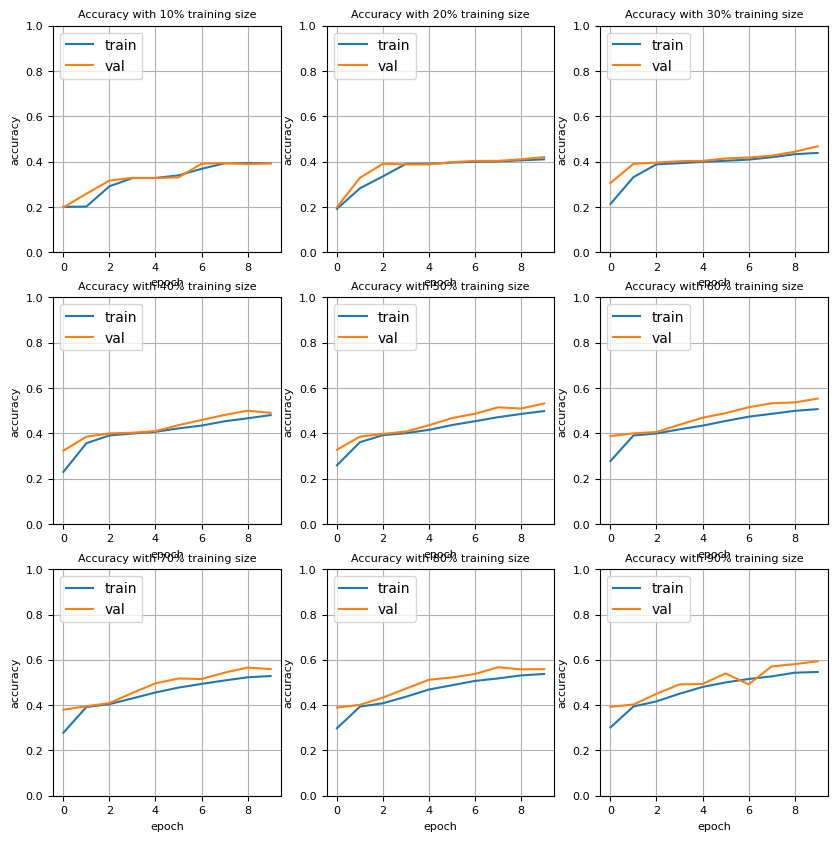

In [19]:
def create_history_plots(histories, sizes):
    plt.figure(figsize=(10, 10))
    for i, history in enumerate(histories):
        plt.subplot(3, 3, i+1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        # set title fontsize a bit lower
        plt.title(f'Accuracy with {int(sizes[i]*100)}% training size', fontsize=8)
        plt.grid()
        plt.ylim(0,1)
        plt.ylabel('accuracy', fontsize=8)
        plt.xlabel('epoch', fontsize=8)
        plt.legend(['train', 'val'], loc='upper left')
        # set x and y values also to fontsize 8
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    plt.show()


histories = [total_scores[key]['history'] for key in total_scores.keys()]
sizes = [key for key in total_scores.keys()]
create_history_plots(histories, sizes)

In [20]:
predictions = model.predict(X_test)
# put them into a readable format
for i in range(len(predictions)):
    print(f"Predicted: {decode_labels(predictions[i])}, True: {decode_labels(y_test[i])}")

63/63 [==============================] - 1s 5ms/step
Predicted: 27 , True: 29 
Predicted: 57 , True: 50 
Predicted: 72 , True: 71 
Predicted: 173, True: 175
Predicted: 49 , True: 38 
Predicted: 10 , True: 105
Predicted: 150, True: 151
Predicted: 57 , True: 51 
Predicted: -1 , True: -9 
Predicted: -1 , True: -11
Predicted: 37 , True: 39 
Predicted: 22 , True: 22 
Predicted: -12, True: -16
Predicted: 150, True: 154
Predicted: 69 , True: 58 
Predicted: 150, True: 145
Predicted: 1  , True: 5  
Predicted: 59 , True: 72 
Predicted: 184, True: 182
Predicted: -1 , True: -9 
Predicted: 129, True: 124
Predicted: 72 , True: 74 
Predicted: 47 , True: 45 
Predicted: 75 , True: 74 
Predicted: -1 , True: -5 
Predicted: 57 , True: 61 
Predicted: 22 , True: 26 
Predicted: 10 , True: 102
Predicted: 22 , True: 15 
Predicted: 79 , True: 87 
Predicted: -53, True: -60
Predicted: 22 , True: 18 
Predicted: 115, True: 111
Predicted: -17, True: -20
Predicted: 49 , True: 48 
Predicted: -  , True: 0  
Predicted: 

In [21]:
decoded_predictions = decode_all(predictions)
decoded_y_test = decode_all(y_test)
correct_num, incorrect_num, correct_indices, incorrect_indices = check_classification(decoded_predictions, decoded_y_test)
print(f"Correct: {correct_num}, Incorrect: {incorrect_num}")
print(f"accuracy: {correct_num/(correct_num+incorrect_num)}")

Correct: 80, Incorrect: 1920
accuracy: 0.04


73 0


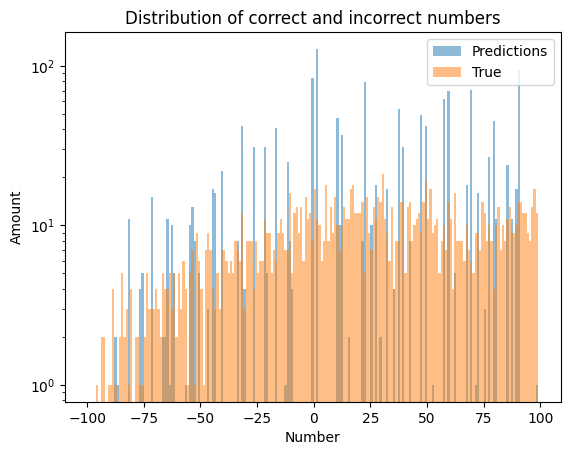

In [22]:
cleaned_wrong_classified, invalid_count_wrong_classified = process_strings(np.array(decoded_predictions)[incorrect_indices])
cleaned_true, invalid_count_true = process_strings(np.array(decoded_y_test)[incorrect_indices])
print(invalid_count_wrong_classified, invalid_count_true)
int_decoded_predictions = [int(x) for x in cleaned_wrong_classified]
int_decoded_y_test = [int(x) for x in decoded_y_test]
plt.hist(int_decoded_predictions, bins=range(-100,100), alpha=0.5, label='Predictions')
plt.hist(int_decoded_y_test, bins=range(-100,100), alpha=0.5, label='True')
plt.legend(loc='upper right')
plt.xlabel('Number')
plt.ylabel('Amount')
plt.title('Distribution of correct and incorrect numbers')
# logarithm y-axis
plt.yscale('log')
plt.show()

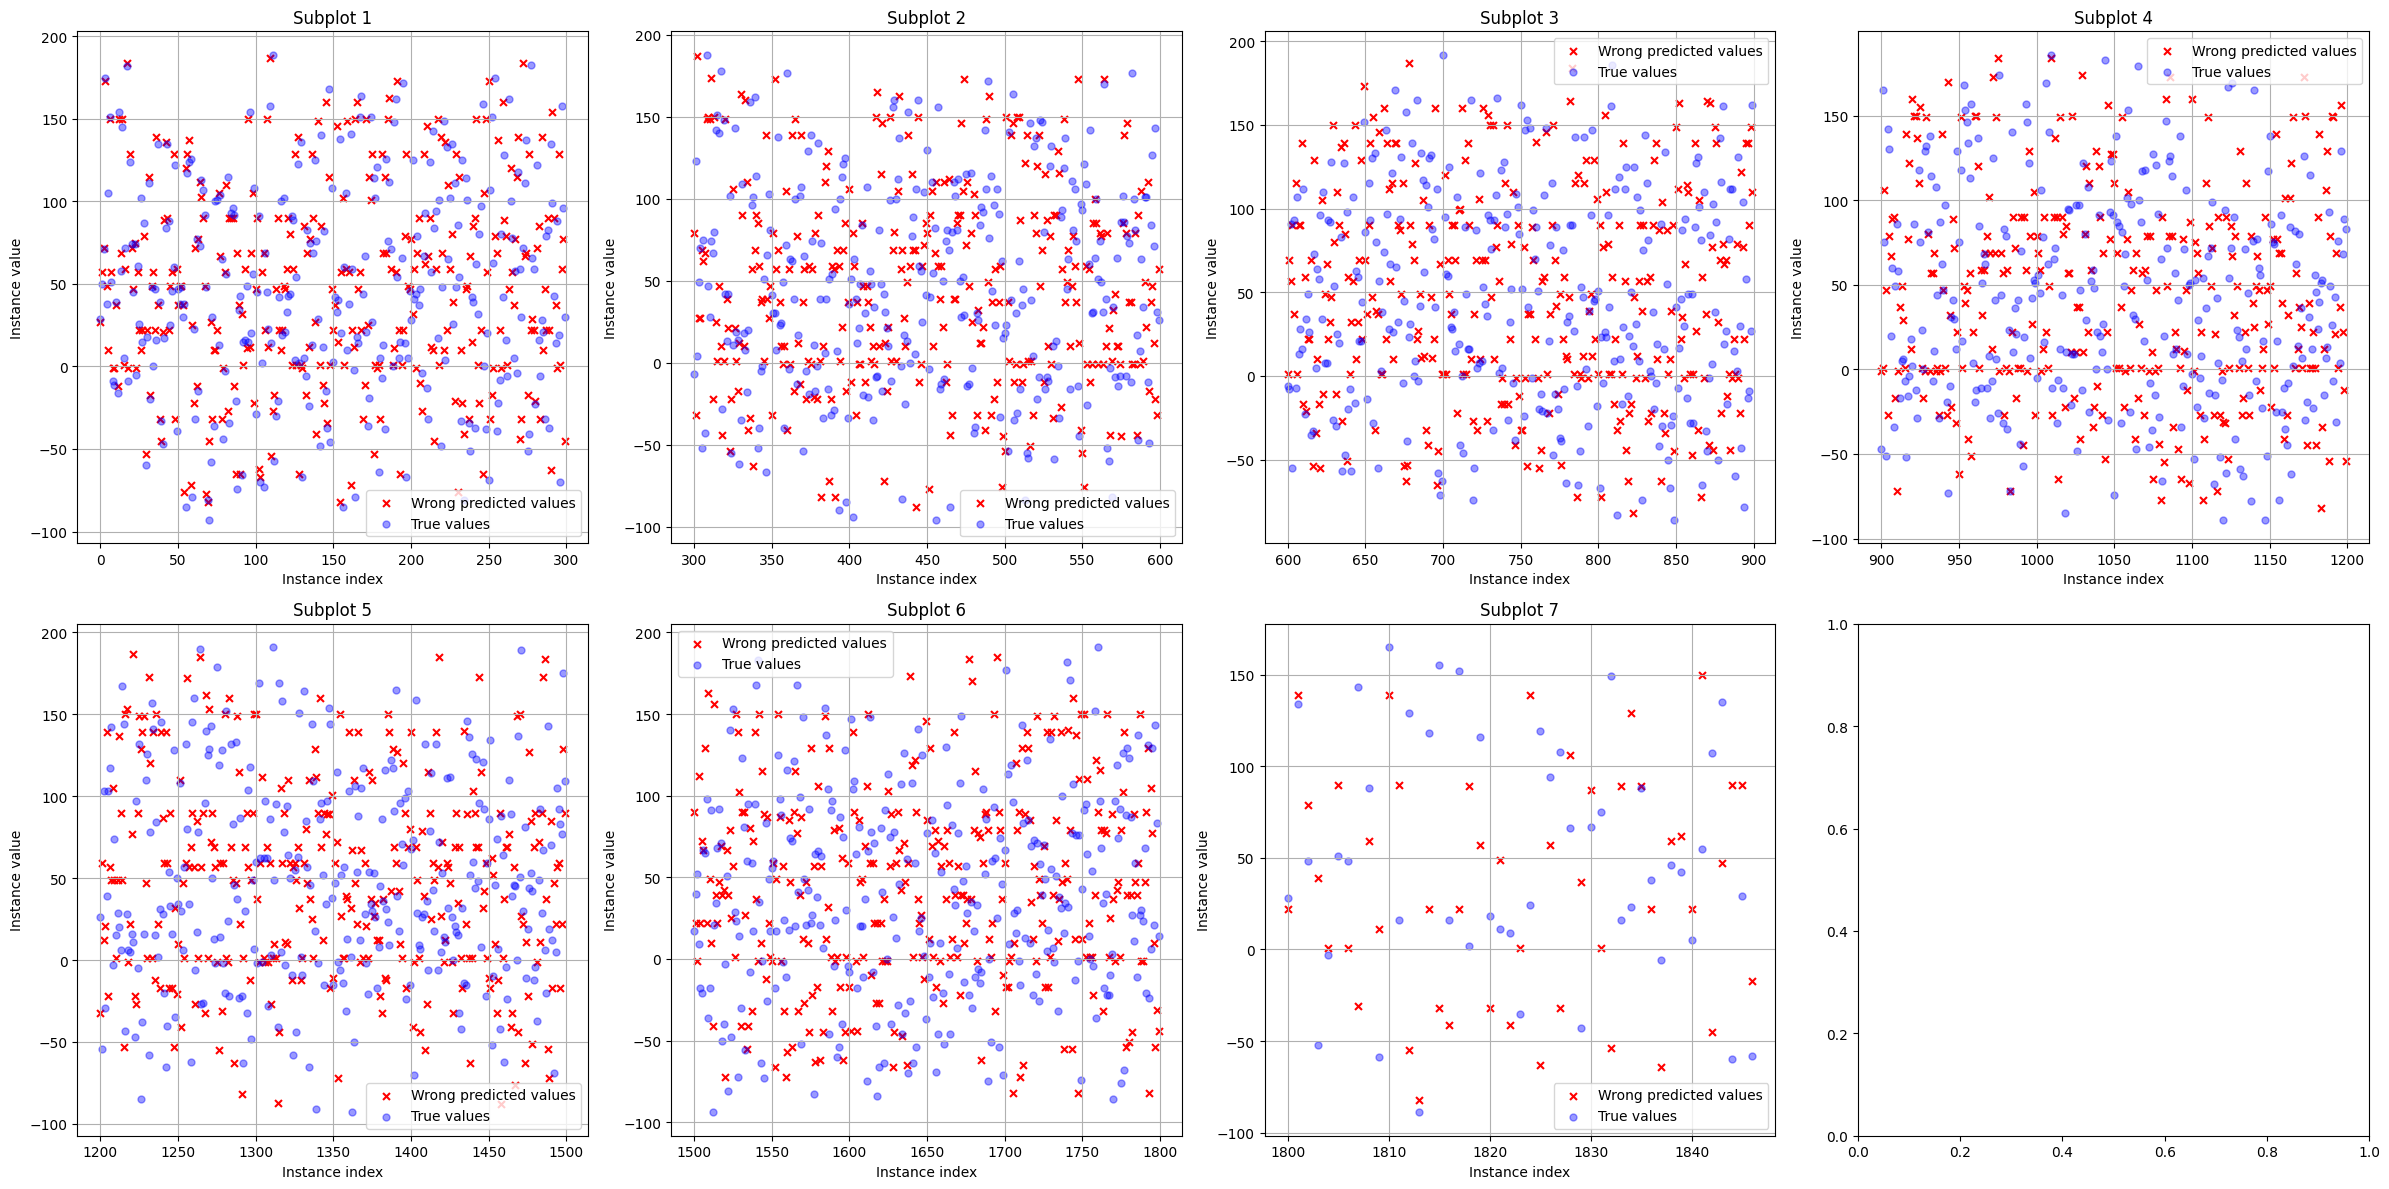

In [23]:
plot_wrong_classified(cleaned_wrong_classified, cleaned_true)


adding multiple layers

In [24]:
best_config_key,best_config

(0.9,
 {'loss': 1.1486085653305054,
  'accuracy': 0.5873333215713501,
  'history': <keras.src.callbacks.History at 0x7f81b8254550>})

In [25]:
def test_num_decode_encode(train_size,num_of_decodes = 1,
                           num_of_encodes = 1):
  # Create datasets
  X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
  results_all = {}
  # Iterate over encoder en decoder numbers
  for i in range(1,num_of_decodes+1):
      for j in range(1,num_of_encodes+1):
        print(f"Testing {i} decode, {j} encode layers")
        model = build_text2text_model(num_encode_layers=j, num_decode_layers=i)
        history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=10, batch_size=128)
        results_all[(i,j)] = {'history': history}
  return results_all
results = test_num_decode_encode(num_of_decodes = 1,
                       num_of_encodes = 5,train_size=best_config_key)

results2 = test_num_decode_encode(num_of_decodes = 5,
                        num_of_encodes = 1,train_size=best_config_key)

Testing 1 decode, 1 encode layers
Epoch 1/10
127/127 [==============================] - 6s 20ms/step - loss: 2.1650 - accuracy: 0.3048 - val_loss: 1.9060 - val_accuracy: 0.3894
Epoch 2/10
127/127 [==============================] - 2s 13ms/step - loss: 1.7932 - accuracy: 0.3949 - val_loss: 1.6621 - val_accuracy: 0.4076
Epoch 3/10
127/127 [==============================] - 2s 12ms/step - loss: 1.6236 - accuracy: 0.4221 - val_loss: 1.5033 - val_accuracy: 0.4596
Epoch 4/10
127/127 [==============================] - 2s 13ms/step - loss: 1.4925 - accuracy: 0.4639 - val_loss: 1.4162 - val_accuracy: 0.4931
Epoch 5/10
127/127 [==============================] - 2s 12ms/step - loss: 1.4160 - accuracy: 0.4855 - val_loss: 1.3584 - val_accuracy: 0.5035
Epoch 6/10
127/127 [==============================] - 2s 13ms/step - loss: 1.3632 - accuracy: 0.5011 - val_loss: 1.2723 - val_accuracy: 0.5454
Epoch 7/10
127/127 [==============================] - 2s 13ms/step - loss: 1.3017 - accuracy: 0.5214 - val_l

In [26]:
results2

{(1, 1): {'history': <keras.src.callbacks.History at 0x7f7f9c240550>},
 (2, 1): {'history': <keras.src.callbacks.History at 0x7f8050bf6a10>},
 (3, 1): {'history': <keras.src.callbacks.History at 0x7f8050886e50>},
 (4, 1): {'history': <keras.src.callbacks.History at 0x7f8053b87910>},
 (5, 1): {'history': <keras.src.callbacks.History at 0x7f805370f390>}}

In [27]:
results

{(1, 1): {'history': <keras.src.callbacks.History at 0x7f806f3834d0>},
 (1, 2): {'history': <keras.src.callbacks.History at 0x7f80501229d0>},
 (1, 3): {'history': <keras.src.callbacks.History at 0x7f806f057710>},
 (1, 4): {'history': <keras.src.callbacks.History at 0x7f806d3eca10>},
 (1, 5): {'history': <keras.src.callbacks.History at 0x7f7fdc48c1d0>}}

In [28]:
# combine the results
results_comb = {**results, **results2}
results_comb

{(1, 1): {'history': <keras.src.callbacks.History at 0x7f7f9c240550>},
 (1, 2): {'history': <keras.src.callbacks.History at 0x7f80501229d0>},
 (1, 3): {'history': <keras.src.callbacks.History at 0x7f806f057710>},
 (1, 4): {'history': <keras.src.callbacks.History at 0x7f806d3eca10>},
 (1, 5): {'history': <keras.src.callbacks.History at 0x7f7fdc48c1d0>},
 (2, 1): {'history': <keras.src.callbacks.History at 0x7f8050bf6a10>},
 (3, 1): {'history': <keras.src.callbacks.History at 0x7f8050886e50>},
 (4, 1): {'history': <keras.src.callbacks.History at 0x7f8053b87910>},
 (5, 1): {'history': <keras.src.callbacks.History at 0x7f805370f390>}}

In [29]:
for key, value in results_comb.items():
    print(key, value['history'].history['val_accuracy'][-1])

(1, 1) 0.5661110877990723
(1, 2) 0.5872222185134888
(1, 3) 0.6368518471717834
(1, 4) 0.6231481432914734
(1, 5) 0.6259258985519409
(2, 1) 0.5916666388511658
(3, 1) 0.6059259176254272
(4, 1) 0.6201851963996887
(5, 1) 0.5912963151931763


In [30]:
best_config = max(results_comb, key=lambda k: results_comb[k]['history'].history['val_accuracy'][-1])
best_config

(1, 3)

In [31]:
# train new cool model
X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
model = build_text2text_model(num_encode_layers=best_config[1], num_decode_layers=best_config[0])
history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=10, batch_size=128)
predictions = model.predict(X_test)

Epoch 1/10
127/127 [==============================] - 9s 32ms/step - loss: 2.1814 - accuracy: 0.3001 - val_loss: 1.9503 - val_accuracy: 0.3830
Epoch 2/10
127/127 [==============================] - 2s 20ms/step - loss: 1.8210 - accuracy: 0.3927 - val_loss: 1.6771 - val_accuracy: 0.4015
Epoch 3/10
127/127 [==============================] - 2s 19ms/step - loss: 1.6377 - accuracy: 0.4193 - val_loss: 1.5416 - val_accuracy: 0.4522
Epoch 4/10
127/127 [==============================] - 3s 20ms/step - loss: 1.5110 - accuracy: 0.4543 - val_loss: 1.3938 - val_accuracy: 0.5022
Epoch 5/10
127/127 [==============================] - 3s 20ms/step - loss: 1.4080 - accuracy: 0.4869 - val_loss: 1.3368 - val_accuracy: 0.5200
Epoch 6/10
127/127 [==============================] - 3s 20ms/step - loss: 1.3213 - accuracy: 0.5141 - val_loss: 1.2017 - val_accuracy: 0.5735
Epoch 7/10
127/127 [==============================] - 2s 19ms/step - loss: 1.2460 - accuracy: 0.5416 - val_loss: 1.1469 - val_accuracy: 0.5980

accuracy: 0.04


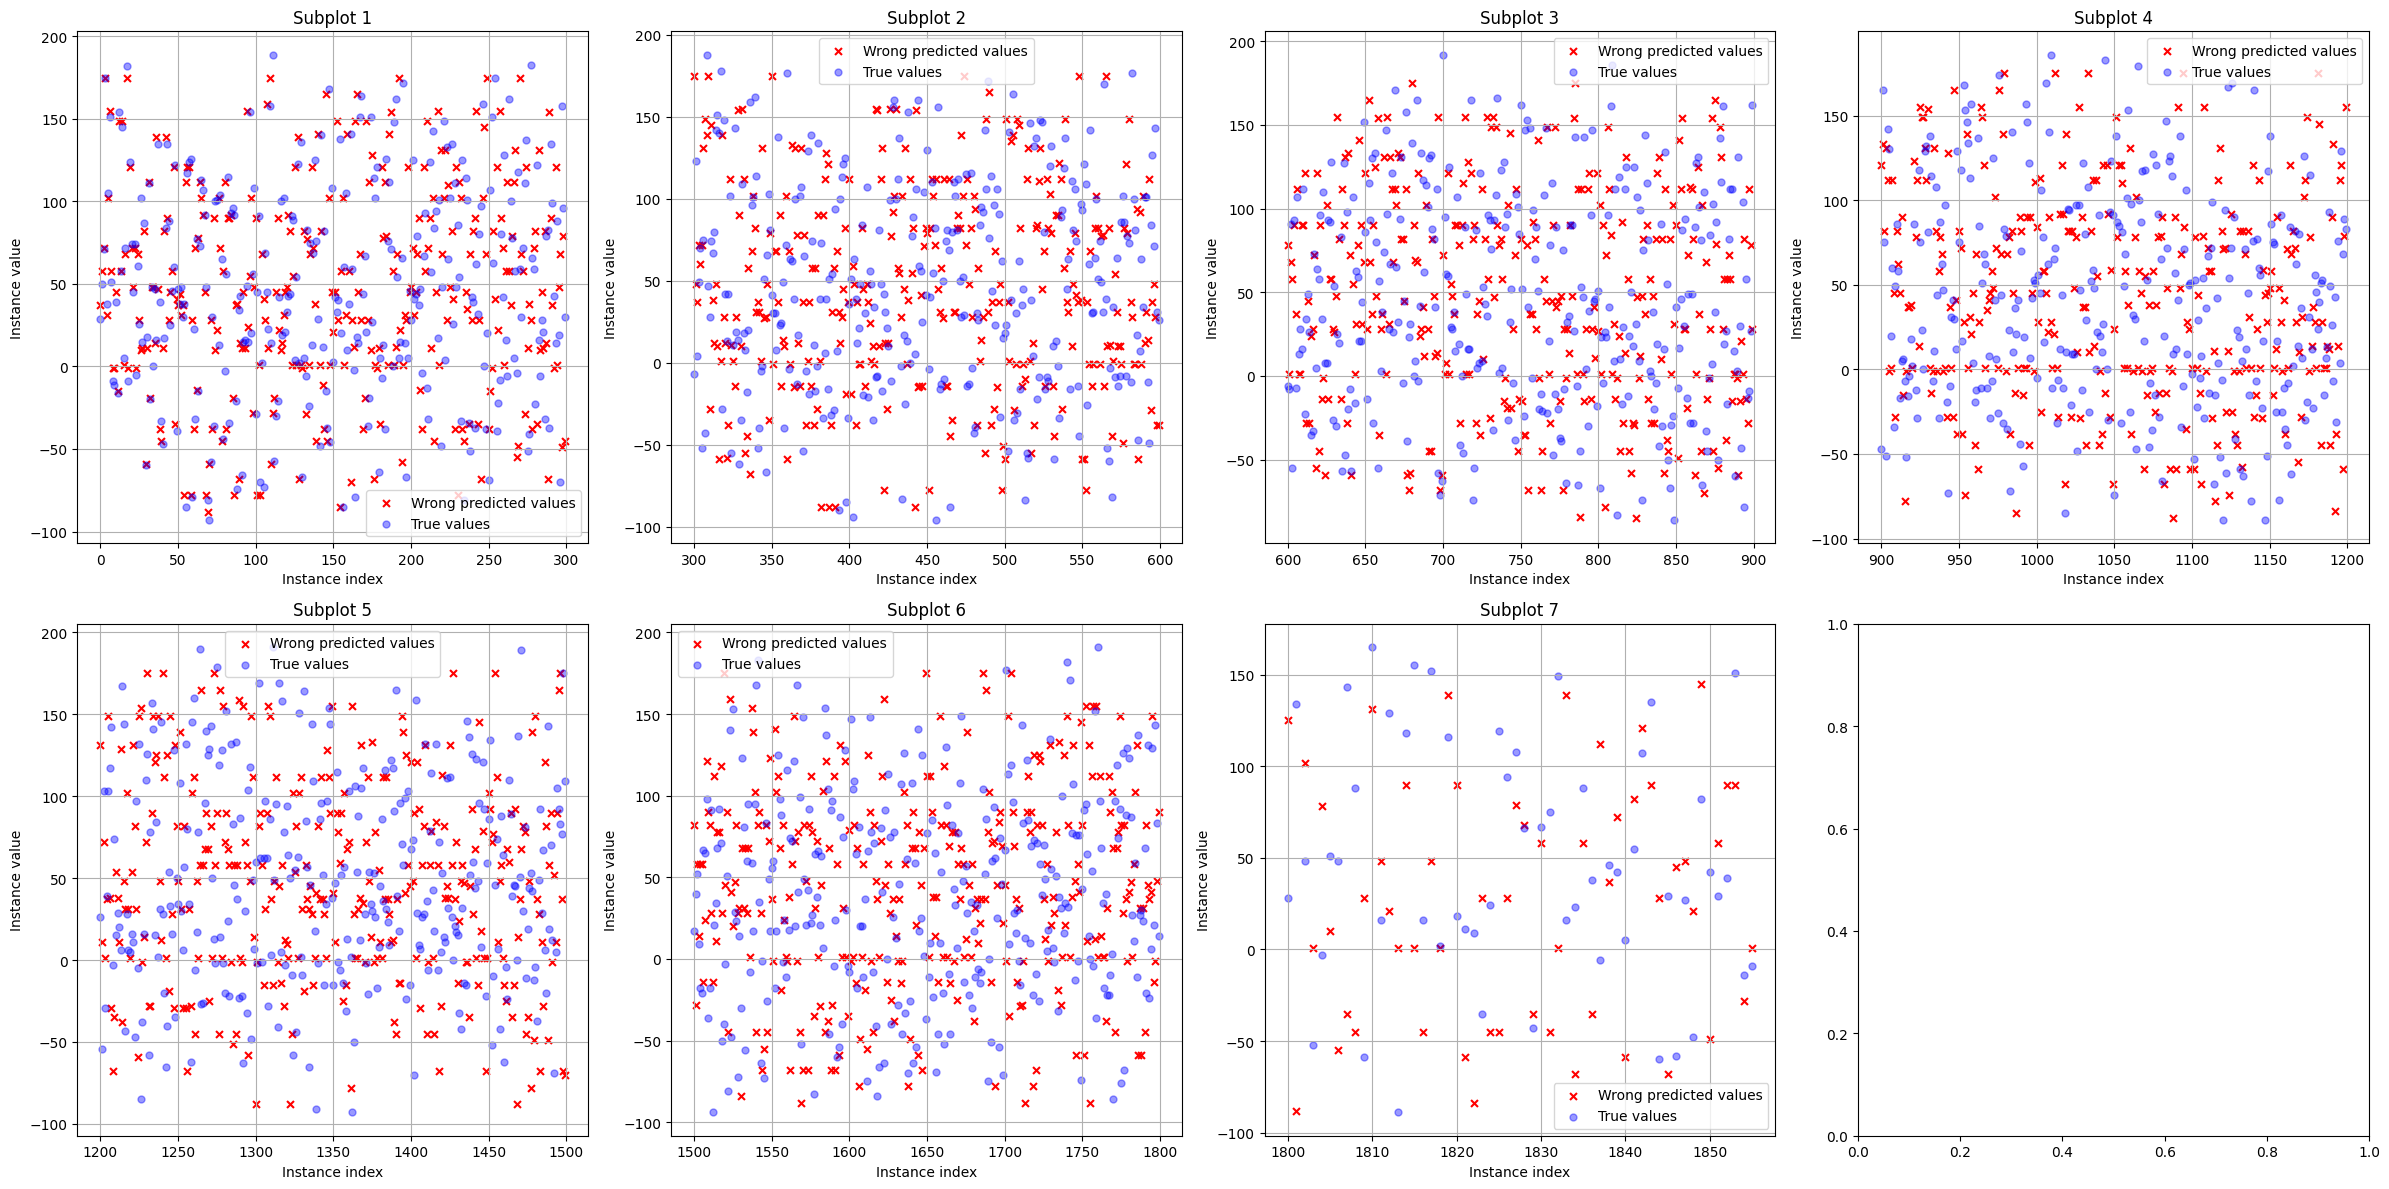

In [32]:
decoded_predictions = decode_all(predictions)
decoded_y_test = decode_all(y_test)
cleaned_wrong_classified, invalid_count_wrong_classified = process_strings(np.array(decoded_predictions)[incorrect_indices])
cleaned_true, invalid_count_true = process_strings(np.array(decoded_y_test)[incorrect_indices])
print(f"accuracy: {correct_num/(correct_num+incorrect_num)}")
plot_wrong_classified(cleaned_wrong_classified, cleaned_true)


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [48]:
def build_img2text_model(num_encode_layers: int = 1,num_decode_layers:int = 1, max_answer_length: int=3):
    img2text = tf.keras.Sequential()
    img2text.add(Input(shape=(5, 28*28)))

    hidden_units = 256
    # Encoder: Add num_encode_layers LSTM layers
    for _ in range(num_encode_layers):
        img2text.add(LSTM(hidden_units, return_sequences=False if _ == num_encode_layers - 1 else True))

    # Repeat the context vector for decoding
    img2text.add(RepeatVector(max_answer_length))

    # Decoder: Add num_decode_layers LSTM layers
    for i in range(num_decode_layers):
        img2text.add(LSTM(hidden_units, return_sequences=True))

    # Output layer: Dense layer with softmax activation for classification
    img2text.add(Dense(len(unique_characters), activation='softmax'))

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    img2text.compile(loss='categorical_crossentropy', optimizer=opt,
                     metrics=['accuracy'], steps_per_execution=25)
    return img2text

In [49]:
X_img_reshaped = X_img.reshape(-1, 5, 28 * 28)
test_size = 0.1
X_train = X_img_reshaped[int(len(X_img_reshaped)*test_size):]
y_train = y_text_onehot[int(len(y_text_onehot)*test_size):]
X_test = X_img_reshaped[:int(len(X_img_reshaped)*test_size)]
y_test = y_text_onehot[:int(len(y_text_onehot)*test_size)]


X_train_batch, X_val_batch, y_train_batch, y_val_batch = train_test_split(X_train , y_train, train_size=best_config_key, random_state=42)
epochs = 10
model = build_img2text_model(num_encode_layers=best_config[1], num_decode_layers=best_config[0])
history = model.fit(X_train,y_train,batch_size=32,validation_data= (X_val_batch, y_val_batch), epochs=epochs)

Epoch 1/10
563/563 [==============================] - 26s 45ms/step - loss: 1.8692 - accuracy: 0.3761 - val_loss: 1.5902 - val_accuracy: 0.4426
Epoch 2/10
563/563 [==============================] - 10s 19ms/step - loss: 1.5128 - accuracy: 0.4571 - val_loss: 1.3942 - val_accuracy: 0.4872
Epoch 3/10
563/563 [==============================] - 10s 17ms/step - loss: 1.3425 - accuracy: 0.5145 - val_loss: 1.2382 - val_accuracy: 0.5519
Epoch 4/10
563/563 [==============================] - 10s 17ms/step - loss: 1.2156 - accuracy: 0.5564 - val_loss: 1.1285 - val_accuracy: 0.5843
Epoch 5/10
563/563 [==============================] - 11s 19ms/step - loss: 1.1177 - accuracy: 0.5892 - val_loss: 1.0521 - val_accuracy: 0.6139
Epoch 6/10
563/563 [==============================] - 10s 18ms/step - loss: 1.0492 - accuracy: 0.6115 - val_loss: 1.0206 - val_accuracy: 0.6185
Epoch 7/10
563/563 [==============================] - 10s 18ms/step - loss: 0.9932 - accuracy: 0.6296 - val_loss: 0.9541 - val_accuracy:

Result:
63/63 [==============================] - 1s 10ms/step - loss: 1.0962 - accuracy: 0.6123


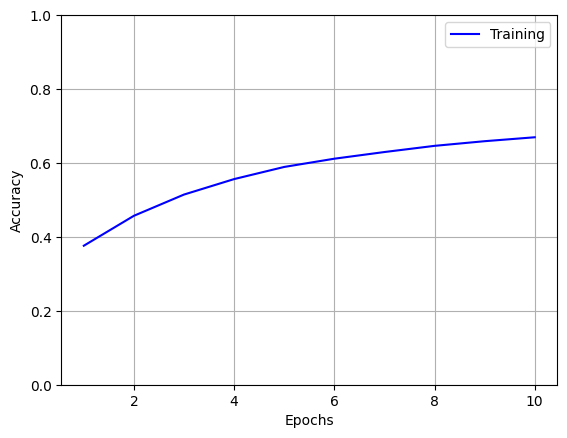

In [50]:
acc = history.history['accuracy']
loss = history.history['loss']
print("Result:")
model.evaluate(X_test,y_test)

plt.plot(np.arange(1, epochs+1), acc, label='Training', color='blue')
plt.grid()
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

63/63 [==============================] - 3s 45ms/step
Correct: 178, Incorrect: 1822
accuracy: 0.089
Recall: 0.089, Precision: 0.052863238497739176, Accuracy: 0.089
19 0
accuracy: 0.089


/home/bartwesthoff/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bartwesthoff/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


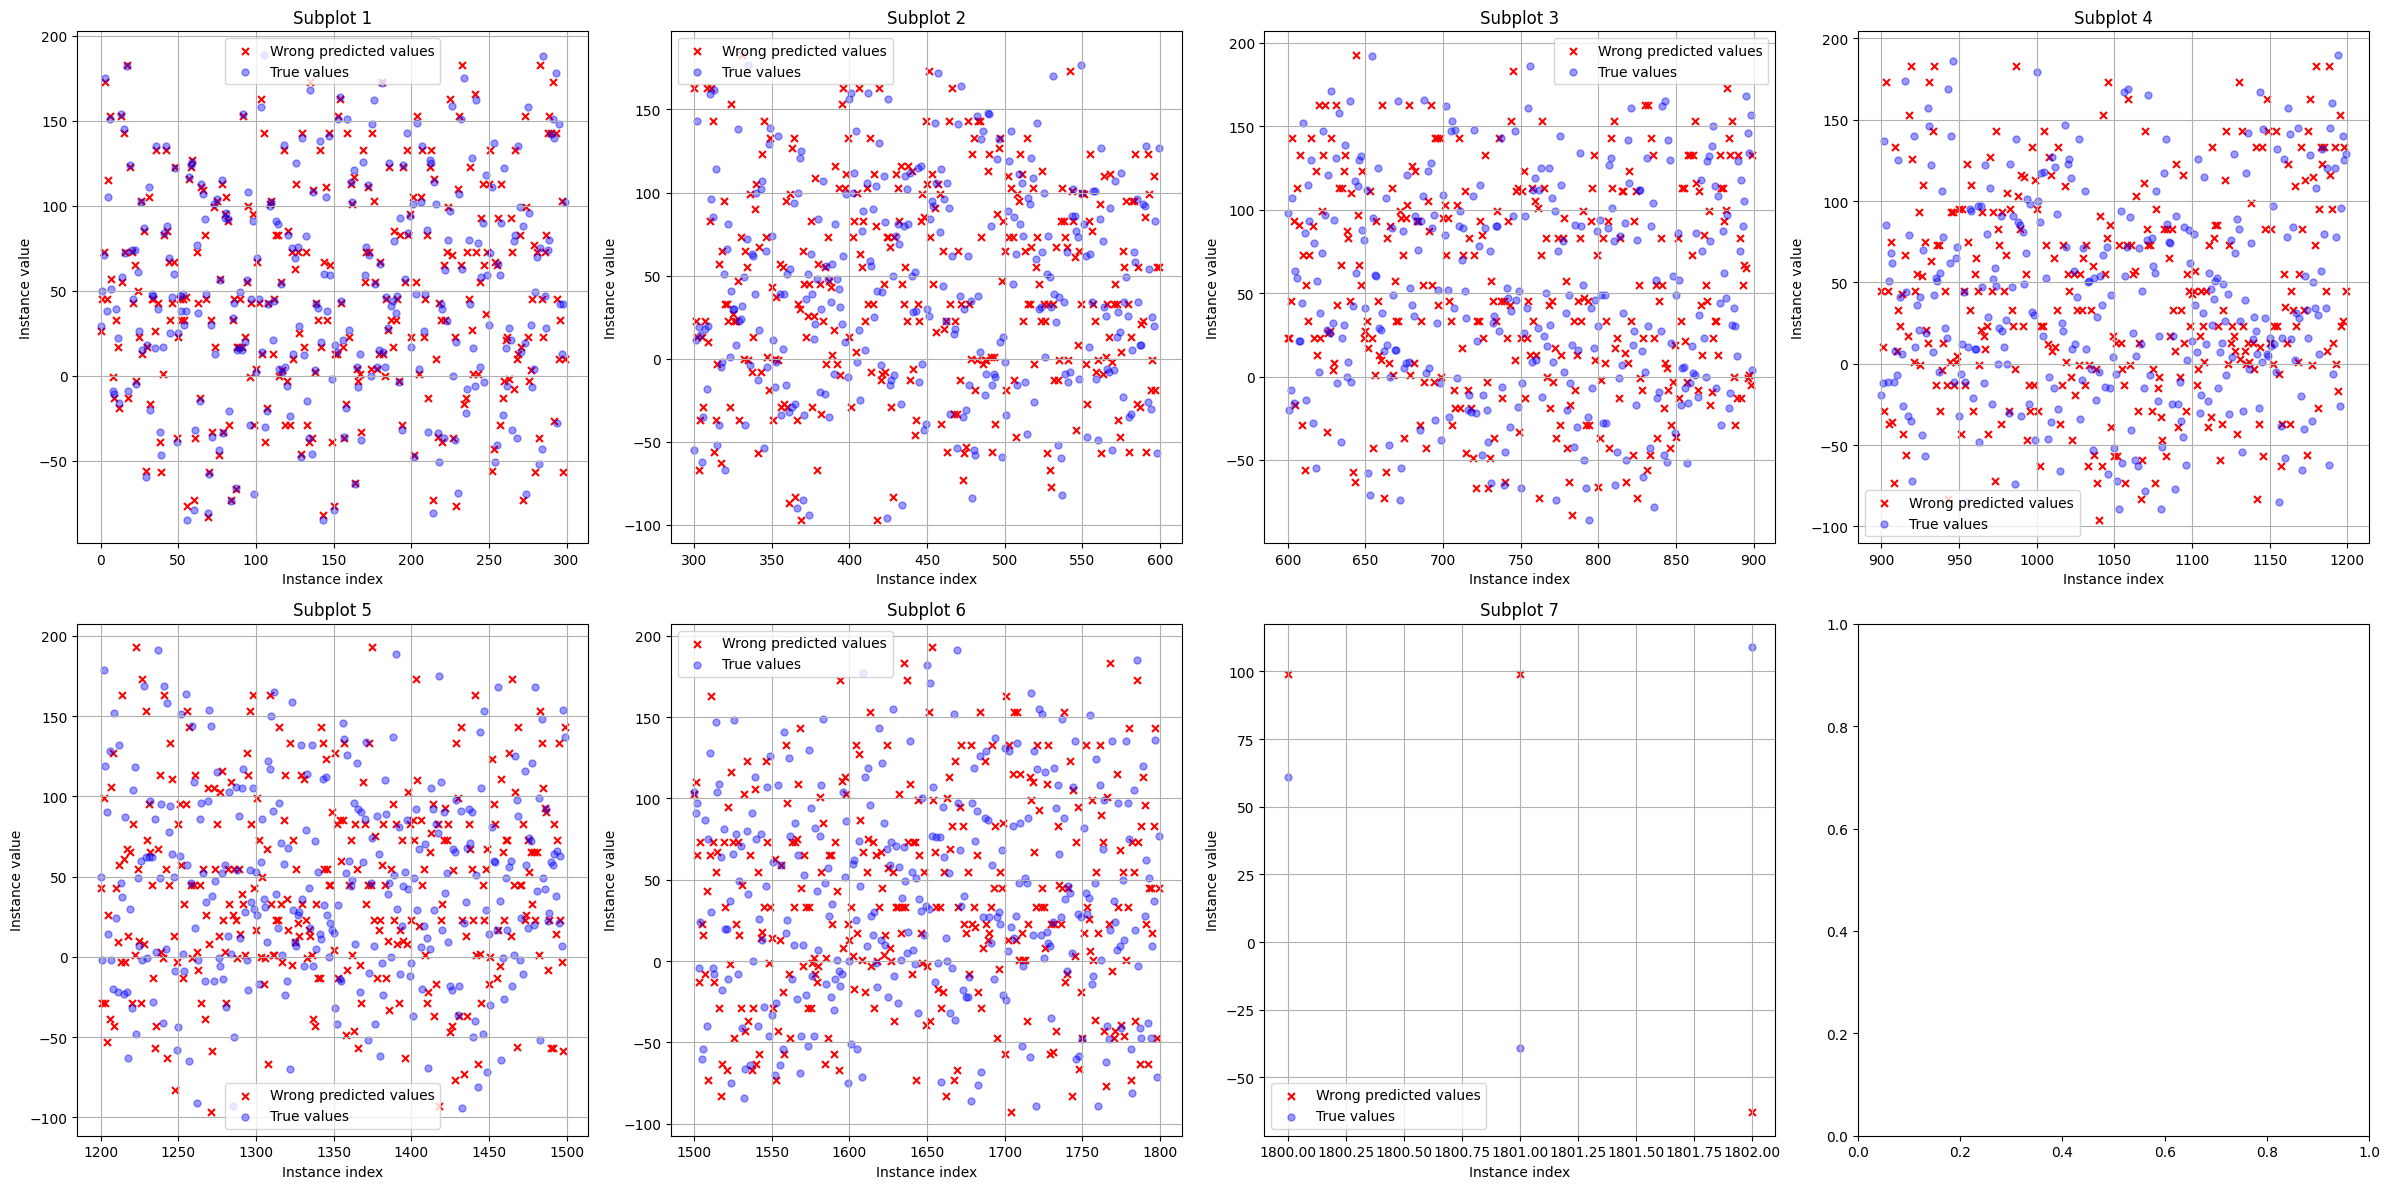

In [51]:
# import recall, precision
predictions = model.predict(X_test)
decoded_predictions = decode_all(predictions)
decoded_y_test = decode_all(y_test)
correct_num, incorrect_num, correct_indices, incorrect_indices = check_classification(decoded_predictions, decoded_y_test)
print(f"Correct: {correct_num}, Incorrect: {incorrect_num}")
print(f"accuracy: {correct_num/(correct_num+incorrect_num)}")
test_recall = recall_score(decoded_y_test, decoded_predictions,average='weighted')
test_precision = precision_score(decoded_y_test, decoded_predictions,average='weighted')
print(f"Recall: {test_recall}, Precision: {test_precision}, Accuracy: {correct_num/(correct_num+incorrect_num)}")

cleaned_wrong_classified, invalid_count_wrong_classified = process_strings(np.array(decoded_predictions)[incorrect_indices])
cleaned_true, invalid_count_true = process_strings(np.array(decoded_y_test)[incorrect_indices])
print(invalid_count_wrong_classified, invalid_count_true)
print(f"accuracy: {correct_num/(correct_num+incorrect_num)}")
plot_wrong_classified(cleaned_wrong_classified, cleaned_true)

Testing 1 decode, 1 encode layers
Epoch 1/10
127/127 [==============================] - 7s 57ms/step - loss: 2.0099 - accuracy: 0.3521 - val_loss: 1.8275 - val_accuracy: 0.3867
Epoch 2/10
127/127 [==============================] - 2s 12ms/step - loss: 1.7533 - accuracy: 0.4008 - val_loss: 1.6947 - val_accuracy: 0.4061
Epoch 3/10
127/127 [==============================] - 2s 12ms/step - loss: 1.6329 - accuracy: 0.4226 - val_loss: 1.6447 - val_accuracy: 0.4230
Epoch 4/10
127/127 [==============================] - 1s 12ms/step - loss: 1.5493 - accuracy: 0.4460 - val_loss: 1.5607 - val_accuracy: 0.4454
Epoch 5/10
127/127 [==============================] - 1s 12ms/step - loss: 1.4714 - accuracy: 0.4697 - val_loss: 1.5305 - val_accuracy: 0.4550
Epoch 6/10
127/127 [==============================] - 1s 12ms/step - loss: 1.4093 - accuracy: 0.4865 - val_loss: 1.4886 - val_accuracy: 0.4752
Epoch 7/10
127/127 [==============================] - 2s 12ms/step - loss: 1.3504 - accuracy: 0.5049 - val_l

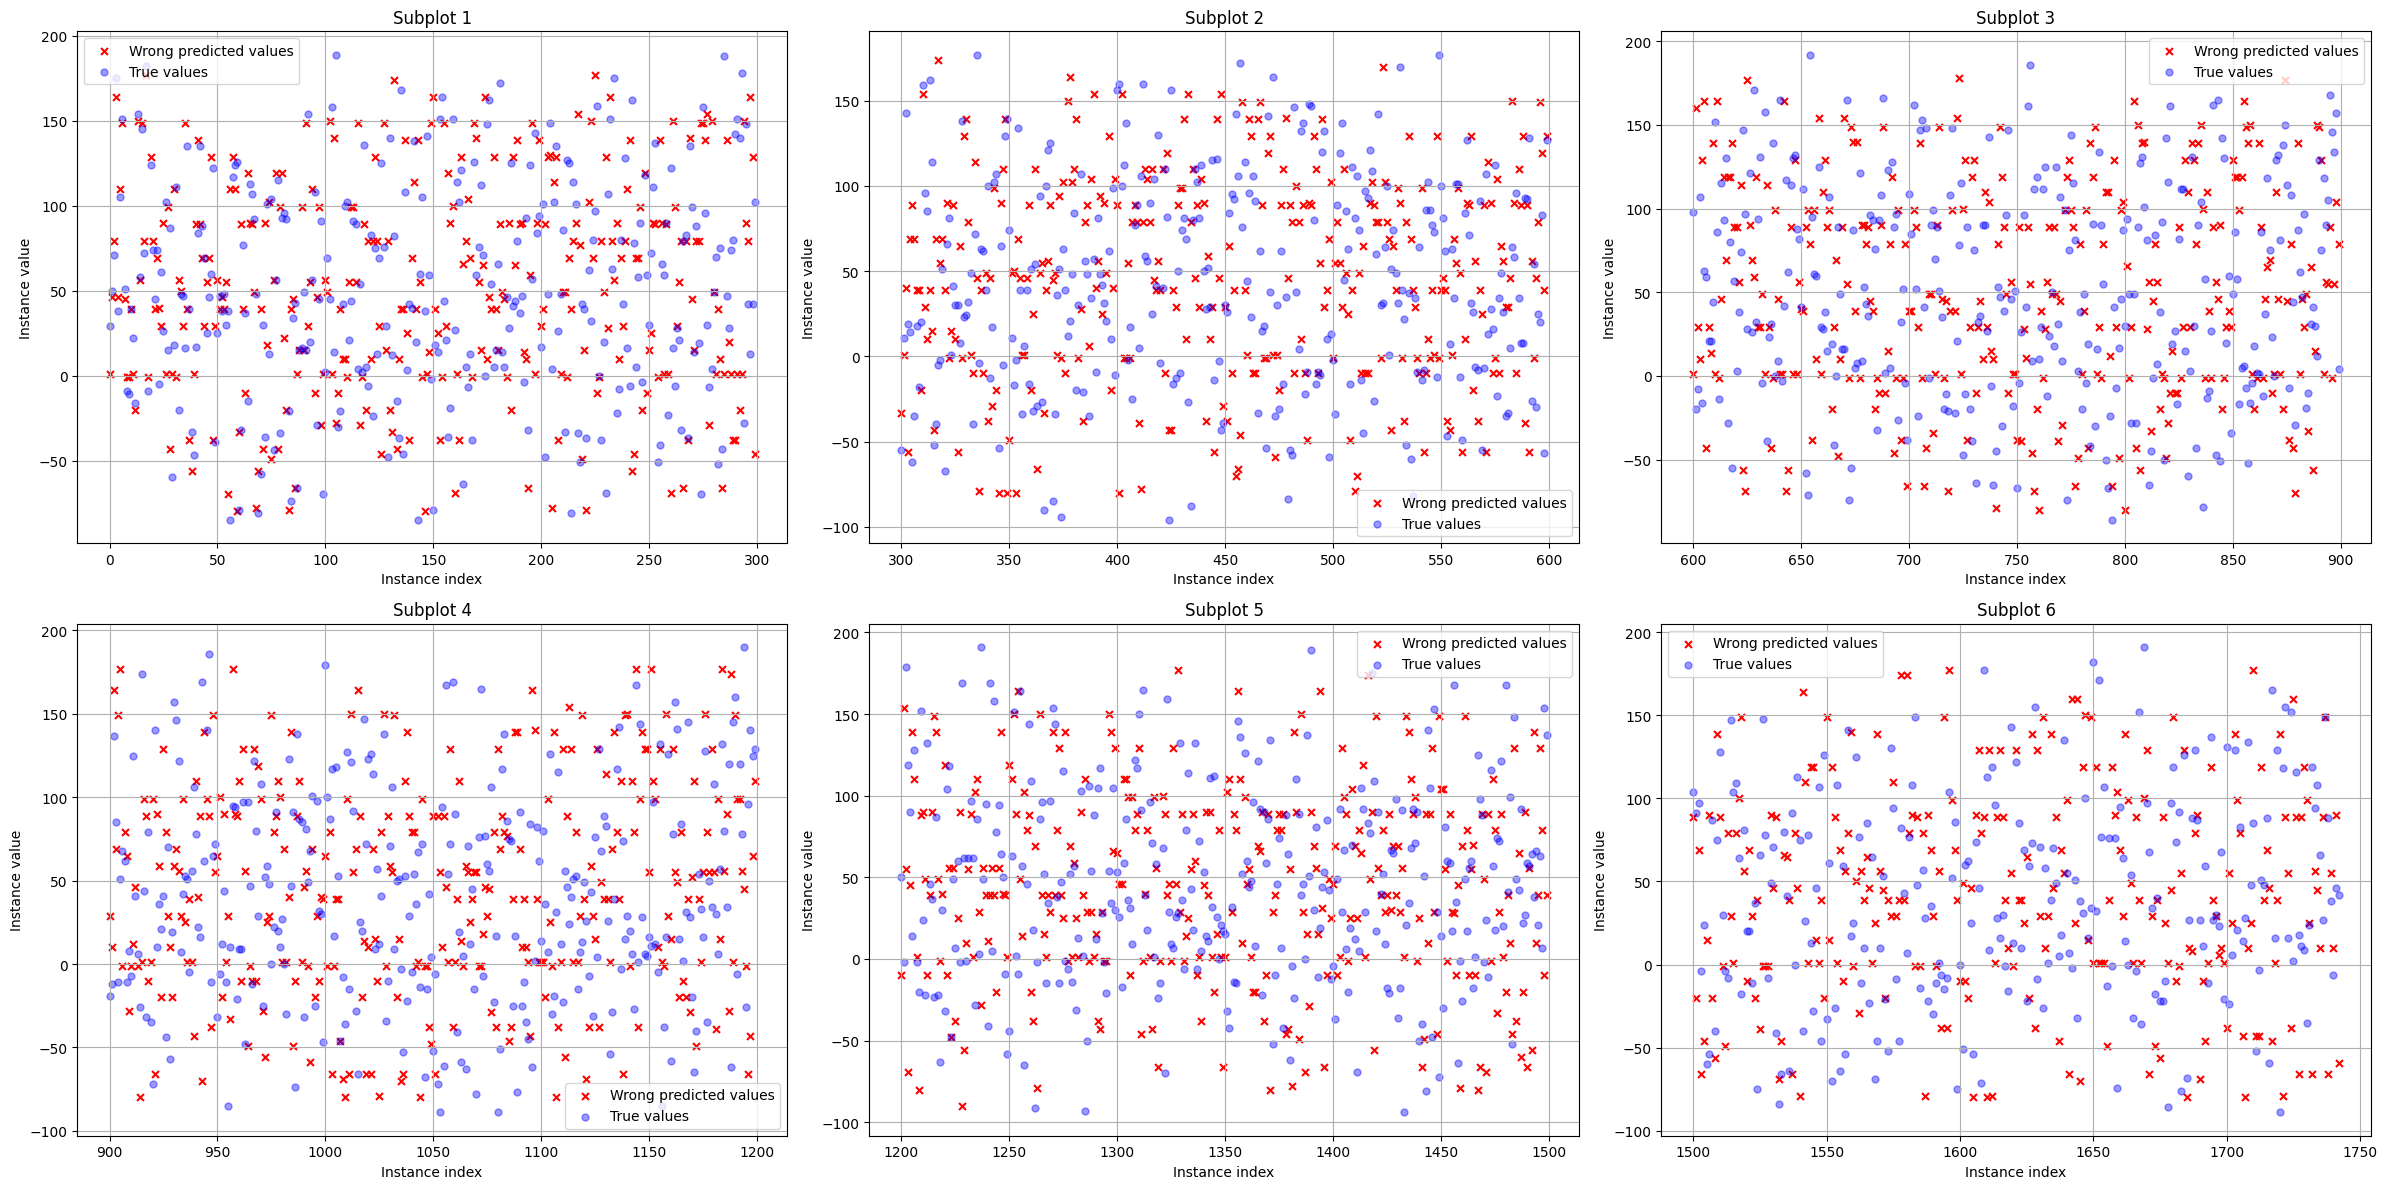

In [52]:
# 1.5
def test_num_decode_encode_img2text(train_size,num_of_decodes = [1,2,3,4,5],
                           num_of_encodes = [1,2,3,4,5]):
  # Create datasets
  X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
  results_all = {}
  # Iterate over encoder en decoder numbers
  for i in num_of_decodes:
    for j in num_of_encodes:
        print(f"Testing {i} decode, {j} encode layers")
        model = build_img2text_model(num_encode_layers=j, num_decode_layers=i)
        history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=10, batch_size=128)
        results_all[(i,j)] = {'history': history}
  return results_all
results_imgtext = test_num_decode_encode_img2text(num_of_decodes = [1,2,3,4,5],
                       num_of_encodes = [1],train_size=0.9) # TODO change naar best config key
results2_imgtext = test_num_decode_encode_img2text(num_of_decodes = [1],
                       num_of_encodes = [1,2,3,4,5],train_size=0.9) # TODO change naar best config key
results_comb_imgtext = {**results_imgtext, **results2_imgtext}
best_config_imgtext = max(results_comb_imgtext, key=lambda k: results_comb_imgtext[k]['history'].history['val_accuracy'][-1])
for key, value in results_comb_imgtext.items():
    print(key, value['history'].history['val_accuracy'][-1])
X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=0.9, random_state=42)
model = build_img2text_model(num_encode_layers=best_config_imgtext[1], num_decode_layers=best_config_imgtext[0])
history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=10, batch_size=128)
predictions = model.predict(X_test)
decoded_predictions = decode_all(predictions)
decoded_y_test = decode_all(y_test)
cleaned_wrong_classified, invalid_count_wrong_classified = process_strings(np.array(decoded_predictions)[incorrect_indices])
cleaned_true, invalid_count_true = process_strings(np.array(decoded_y_test)[incorrect_indices])
print(f"accuracy: {correct_num/(correct_num+incorrect_num)}")
plot_wrong_classified(cleaned_wrong_classified, cleaned_true)

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [58]:
# Your code
def build_text2img_model(num_encode_layers=1, num_decode_layers=1, max_answer_length=5):
    model = tf.keras.Sequential()
    
    # Encoder: Dynamically add LSTM layers
    for i in range(num_encode_layers):
        return_sequences = (i < num_encode_layers - 1)  # Only the last encoder layer doesn't return sequences
        model.add(LSTM(512, return_sequences=return_sequences, input_shape=(3, 13), name=f"encoder_lstm_{i + 1}"))
        model.add(Dropout(0.4, name=f"encoder_dropout_{i + 1}"))
    
    # Repeat vector to match the number of outputs (5 images in a sequence)
    model.add(RepeatVector(max_answer_length, name="repeat_vector"))  # (batch_size, max_answer_length, 512)
    
    # Decoder: Dynamically add LSTM layers
    for i in range(num_decode_layers):
        model.add(LSTM(256 if i == 0 else 128, return_sequences=True, name=f"decoder_lstm_{i + 1}"))
        model.add(Dropout(0.4, name=f"decoder_dropout_{i + 1}"))
    
    # Generate the spatial features for each time step
    model.add(TimeDistributed(Dense(7 * 7 * 128, activation='relu'), name="time_dense"))
    model.add(TimeDistributed(Reshape((7, 7, 128)), name="time_reshape"))
    
    # Transpose convolutions to upscale to (28, 28)
    model.add(TimeDistributed(Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'), name="conv2d_transpose_1"))
    model.add(TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'), name="conv2d_transpose_2"))
    model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), padding='same', activation='relu'), name="conv2d_transpose_3"))
    model.add(TimeDistributed(Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid'), name="output"))
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

model = build_text2img_model()
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_lstm_1 (LSTM)       (None, 512)               1077248   
                                                                 
 encoder_dropout_1 (Dropout  (None, 512)               0         
 )                                                               
                                                                 
 repeat_vector (RepeatVecto  (None, 5, 512)            0         
 r)                                                              
                                                                 
 decoder_lstm_1 (LSTM)       (None, 5, 256)            787456    
                                                                 
 decoder_dropout_1 (Dropout  (None, 5, 256)            0         
 )                                                               
                                                     

In [55]:
X_img_reshaped = X_img.reshape(-1, 5, 28,28)
test_size = 0.1
y_train = X_img_reshaped[int(len(X_img_reshaped)*test_size):]
X_train = y_text_onehot[int(len(y_text_onehot)*test_size):]
y_test = X_img_reshaped[:int(len(X_img_reshaped)*test_size)]
X_test = y_text_onehot[:int(len(y_text_onehot)*test_size)]

X_train_batch, X_val_batch, y_train_batch, y_val_batch = train_test_split(X_train , y_train, train_size=best_config_key, random_state=42)
epochs = 10
model = build_text2img_model(max_answer_length=5)
history = model.fit(X_train,y_train,batch_size=128,validation_data= (X_val_batch, y_val_batch), epochs=epochs)
predictions = model.predict(X_test)


Epoch 1/10
141/141 [==============================] - 13s 60ms/step - loss: 0.0801 - mse: 0.0801 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 2/10
141/141 [==============================] - 8s 54ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0591 - val_mse: 0.0591
Epoch 3/10
141/141 [==============================] - 8s 54ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 4/10
141/141 [==============================] - 8s 53ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 5/10
141/141 [==============================] - 8s 53ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 6/10
141/141 [==============================] - 8s 54ms/step - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 7/10
141/141 [==============================] - 8s 54ms/step - loss: 0.0587 - mse: 0.0587 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 8/10
141/141 [==============================] - 8s 53ms/step -

(2000, 5, 28, 28, 1)


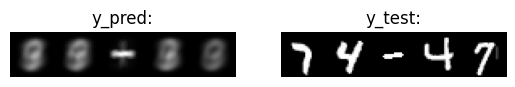

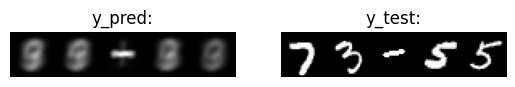

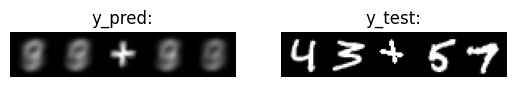

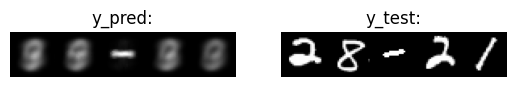

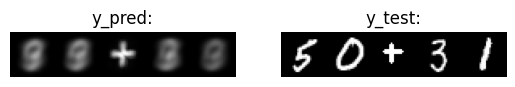

In [56]:
def display_sample_prediction(n):
    labels = ['y_pred:', 'y_test:']
    for j, data in enumerate([predictions, y_test]):
        plt.subplot(1,2,j+1)
        plt.axis('off')
        plt.title(labels[j])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    plt.show()

print(predictions.shape)
for i in np.random.randint(0,predictions.shape[0],5):
  display_sample_prediction(i)

In [59]:
def test_num_decode_encode_text2img(train_size,num_of_decodes = [1,2,3,4,5],
                           num_of_encodes = [1,2,3,4,5]):
  # Create datasets
  X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
  results_all = {}
  # Iterate over encoder en decoder numbers
  for i in num_of_decodes:
    for j in num_of_encodes:
        print(f"Testing {i} decode, {j} encode layers")
        model = build_text2img_model(num_encode_layers=j, num_decode_layers=i,max_answer_length=5)
        history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=10, batch_size=128)
        results_all[(i,j)] = {'history': history}
  return results_all

results_text2img= test_num_decode_encode_text2img(num_of_decodes = [1,2,3,4,5],
                       num_of_encodes = [1],train_size=0.9) # TODO change naar best config key


Testing 1 decode, 1 encode layers
Epoch 1/10
127/127 [==============================] - 12s 57ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 2/10
127/127 [==============================] - 7s 52ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 3/10
127/127 [==============================] - 7s 53ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 4/10
127/127 [==============================] - 7s 54ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 5/10
127/127 [==============================] - 7s 53ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 6/10
127/127 [==============================] - 6s 51ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 7/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 8/10
127/127 [==============

2024-12-13 20:47:23.828944: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  4/127 [..............................] - ETA: 7s - loss: 0.2324 - mse: 0.2324 

2024-12-13 20:47:24.888283: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 20:47:24.947919: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 20:47:25.004544: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 20:47:25.061804: W external/local_tsl/tsl/framewor

  8/127 [>.............................] - ETA: 6s - loss: 0.2214 - mse: 0.2214

2024-12-13 20:47:25.122774: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 20:47:25.180896: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 20:47:25.235581: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-13 20:47:25.291347: W external/local_tsl/tsl/framewor

 12/127 [=>............................] - ETA: 6s - loss: 0.1966 - mse: 0.1966

2024-12-13 20:47:25.348056: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


127/127 [==============================] - 15s 68ms/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 2/10
127/127 [==============================] - 8s 59ms/step - loss: 0.0611 - mse: 0.0611 - val_loss: 0.0595 - val_mse: 0.0595
Epoch 3/10
127/127 [==============================] - 7s 59ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 4/10
127/127 [==============================] - 7s 59ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 5/10
127/127 [==============================] - 8s 59ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 6/10
127/127 [==============================] - 7s 59ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 7/10
127/127 [==============================] - 7s 58ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 8/10
127/127 [==============================] - 7s 59ms/step - loss: 0.05

2024-12-13 20:48:59.424318: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 122.50MiB (rounded to 128450560)requested by op sequential_68/conv2d_transpose_2/conv2d_transpose_61/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-12-13 20:48:59.425318: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-12-13 20:48:59.425440: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 1316, Chunks in use: 1315. 329.0KiB allocated for chunks. 328.8KiB in use in bin. 27.7KiB client-requested in use in bin.
2024-12-13 20:48:59.425460: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 41, Chunks in use: 41. 22.0KiB allocated for chunks. 22.0KiB in use 

ResourceExhaustedError: Graph execution error:

Detected at node sequential_68/conv2d_transpose_2/conv2d_transpose_61/conv2d_transpose defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_42623/243302771.py", line 15, in <module>

  File "/tmp/ipykernel_42623/243302771.py", line 11, in test_num_decode_encode_text2img

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/layers/rnn/time_distributed.py", line 246, in call

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call

  File "/home/bartwesthoff/.local/lib/python3.11/site-packages/keras/src/backend.py", line 6268, in conv2d_transpose

OOM when allocating tensor with shape[640,64,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_68/conv2d_transpose_2/conv2d_transpose_61/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1119757]

In [ ]:
results2_text2img = test_num_decode_encode_text2img(num_of_decodes = [1],
                       num_of_encodes = [1,2,3,4,5],train_size=0.9) # TODO change naar best config key
results_comb_text2img = {**results_text2img, **results2_text2img}
best_config_text2img = max(results_comb_text2img, key=lambda k: results_comb_text2img[k]['history'].history['val_mse'][-1])
for key, value in results_comb_text2img.items():
    print(key, value['history'].history['val_mse'][-1])
X_train_batch, X_val_batch,y_train_batch, y_val_batch = train_test_split(X_train, y_train, train_size=0.9, random_state=42)
model = build_img2text_model(num_encode_layers=best_config_text2img[1], num_decode_layers=best_config_text2img[0])
history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val_batch, y_val_batch),epochs=10, batch_size=128)
predictions = model.predict(X_test)

In [ ]:
def display_sample_prediction(n):
    labels = ['y_pred:', 'y_test:']
    for j, data in enumerate([predictions, y_test]):
        plt.subplot(1,2,j+1)
        plt.axis('off')
        plt.title(labels[j])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    plt.show()

print(predictions.shape)
for i in np.random.randint(0,predictions.shape[0],5):
  display_sample_prediction(i)